In [ ]:
# Libraries 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import bigrams, trigrams
from collections import Counter
from collections import defaultdict
import random
from operator import mul
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

print("Successfully imported all packages")

Successfully imported all packages


## Data

In [ ]:
data = pd.read_csv('Data/socialmedia-disaster-tweets-DFE 3.csv', error_bad_lines=False)
data = data.drop(columns=["_unit_id", "_golden", "_unit_state", "_trusted_judgments","choose_one:confidence", "choose_one_gold", "_last_judgment_at"])
data["target"] = data.apply(lambda row: 1 if row["choose_one"]== "Relevant" else 0 ,axis =1)
full_dataset = data

## EDA

Explore dataset dimensionality:
1. Any missing values?
2. How many datapoints of each class?
3. Average length of tweets in each class + box plot
4. How many words in total?
5. How many unique words?
6. How many unique words after stop word removal?
6. How many unique words after lemmitization?


In [ ]:
# Task 1 - we conclude that Location and Keyword have significant amounts of NAs 
full_dataset.count()

choose_one    10876
keyword       10789
location       7238
text          10876
tweetid       10876
userid        10789
target        10876
dtype: int64

In [ ]:
# Check for NAs in classes of relevance - non found 
print('Target: ', full_dataset[['target']].isna().sum())
print('Text: ', full_dataset[['text']].isna().sum())

Target:  target    0
dtype: int64
Text:  text    0
dtype: int64


In [ ]:
# Task 2 - numer of instances of each class
x = pd.DataFrame(full_dataset[['target']].value_counts())
print(x)

# Calculate percentages
zero = x.iat[0,0] / x[0].sum()
ones = x.iat[1,0] / x[0].sum()

print('zeroes %: ', zero *100)
print('ones %: ', ones*100)

           0
target      
0       6203
1       4673
zeroes %:  57.03383596910629
ones %:  42.96616403089371


In [ ]:
# Task 3.1 - average length of tweet
full_dataset['word_count'] = full_dataset['text'].str.split().str.len() # Count words of tweet and add to new column in df
print(full_dataset.groupby('target')['word_count'].mean()) # Group by target and average over the column

target
0    14.709012
1    15.205007
Name: word_count, dtype: float64


In [ ]:
# Task 3.2 - BoxPlot of the classes

# Extract values
trg = full_dataset.groupby('target')
wordcount_0 = trg.get_group(0)
wordcount_1 = trg.get_group(1)

zeroes_wordcount = wordcount_0[['word_count']]
ones_wordcount = wordcount_1[['word_count']]

zeroes_wordcount = zeroes_wordcount[['word_count']].to_numpy().flatten()
ones_wordcount = ones_wordcount[['word_count']].to_numpy().flatten()

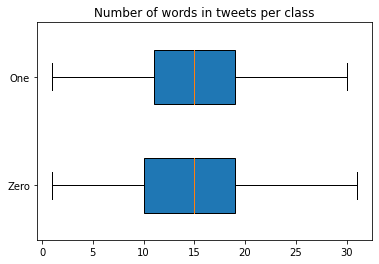

In [ ]:
# Boxplot
bp_data = [zeroes_wordcount, ones_wordcount]
fig, ax = plt.subplots()
ax.set_title('Number of words in tweets per class')
ax.boxplot(bp_data, patch_artist = True, vert = False, labels = ('Zero', 'One'), widths=0.5)

plt.show()

In [ ]:
# Min max length tweet

min_z = min(full_dataset['word_count'])
min_o = min(full_dataset['word_count'])
print(min([min_z, min_o]))

max_z = max(full_dataset['word_count'])
max_o = max(full_dataset['word_count'])
print(max([max_z, max_o]))

1
31


In [ ]:
# Task 4 - total amount of words
print('Number of words in dataset: ', full_dataset['word_count'].sum())
# Words per class
print('Number of words per class: ', full_dataset.groupby('target')['word_count'].sum())

words_in_class = pd.DataFrame(full_dataset.groupby('target')['word_count'].sum())

print('Percentages') # Calculate percentages of words beloning to each class
print('Zeroes: ', (words_in_class.iat[0,0] / (words_in_class.iat[0,0] + words_in_class.iat[1,0]))*100)
print('Ones: ', (words_in_class.iat[1,0] / (words_in_class.iat[0,0] + words_in_class.iat[1,0]))*100)

Number of words in dataset:  162293
Number of words per class:  target
0    91240
1    71053
Name: word_count, dtype: int64
Percentages
Zeroes:  56.219307055757184
Ones:  43.78069294424282


In [ ]:
# Task 5 - n.o. unique words
all_words_list = data['text'].tolist()

#print(all_words_list)

# Create list with all words in the text column
all_words = []
for ls in all_words_list:
    for word in ls.split():
        all_words.append(word.lower())

# Remove duplicates
all_words_set = set(all_words)
print('Number of unique words: ', len(all_words_set))

Number of unique words:  36613


In [ ]:
# Most frequent word and special char
all_words_sort = sorted(all_chars)

count_words = {}
iterator = 0
count = 1
for iterator in range(len(all_words_sort) - 1):
    if all_words_sort[iterator] == all_words_sort[iterator + 1]:
        count += 1
        count_words[all_words_sort[iterator]] = count
        #count_words.append((all_words_sort[iterator], count))
    else:
        count_words[all_words_sort[iterator]] = count
        #count_words.append((all_words_sort[iterator], count))
        count = 0

dict_count = {k: v for k, v in sorted(count_words.items(), key=lambda item: item[1])}

In [ ]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n_place = len(dict_count)
n_items = take(n_place, dict_count.items())

print(n_items[-100:])


[('>', 0), ('\x81', 0), ('¬', 0), ('´', 0), ('«', 1), ('ã', 1), ('ä', 1), ('ç', 1), ('ü', 1), ('`', 2), ('¤', 2), ('á', 2), ('¡', 3), ('à', 3), ('ñ', 3), ('â', 4), (',', 5), ('{', 5), ('¼', 5), ('è', 5), ('\\', 6), ('}', 6), ('¨', 7), ('^', 8), ('£', 8), ('©', 13), ('¢', 18), ('ì', 41), ('~', 46), ('ó', 54), ('\x9d', 60), ('÷', 61), ('%', 62), ('=', 65), ('$', 66), ('ò', 75), ('ê', 92), ('ï', 94), ('+', 107), ('å', 137), (']', 188), ('[', 190), ('|', 214), ('ª', 271), ('*', 273), ('(', 504), (')', 545), ('&', 650), (';', 835), ('û', 1162), ('‰', 1165), ('_', 1253), ('8', 1605), ('6', 1664), ('!', 1667), ('9', 1714), ('7', 1786), ('4', 1907), ('3', 2158), ('5', 2163), ('-', 2448), ('2', 2491), ('q', 2835), ('1', 3198), ('0', 3504), ('z', 3555), ('x', 3945), ('@', 4038), ('?', 4457), ("'", 4470), ('j', 4608), ('#', 4945), (':', 9908), ('v', 10463), ('k', 11447), ('b', 16614), ('.', 16838), ('w', 16840), ('y', 17664), ('f', 17999), ('g', 19559), ('/', 20919), ('m', 24320), ('p', 24648), (

In [ ]:
# Task 6 - How many unique words after tokenization removal?
tok_full = data['tweet_tokens']
tok_all_words = []

for ls in tok_full:
    for word in ls:
        tok_all_words.append(word.lower())
tok_all_words_set = set(tok_all_words)

print('Number of unique words after tokenization ', len(tok_all_words_set))

Number of unique words after tokenization  36613


In [ ]:
# Task 6 - How many unique words after stop word removal?
stop_full = data['cleaned_tweets']
stop_all_words = []

for ls in stop_full:
    for word in ls:
        stop_all_words.append(word.lower())
stop_all_words_set = set(stop_all_words)

print('Number of unique words after removing stop words: ', len(stop_all_words_set))

Number of unique words after removing stop words:  36595


In [ ]:
# Task 7 - How many unique words after lemmitization?

lemmatized_full = data['lemmatized_tweets']
lemmatized_all_words = []

for ls in lemmatized_full:
    for word in ls:
        lemmatized_all_words.append(word.lower())
lemmatized_all_words_set = set(lemmatized_all_words)

print('Number of unique words after lemmatization: ', len(lemmatized_all_words_set))

Number of unique words after lemmatization:  35995


In [ ]:
# Unique characters in data
all_chars = []
for word in all_words:
    for char in word:
        all_chars.append(char)

all_chars_set = set(all_chars)
sort_char = sorted(all_chars_set)
print('Number of unique characters in dataset: ', len(all_chars_set))
print(sort_char)

Number of unique characters in dataset:  97
['!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x81', '\x9d', '¡', '¢', '£', '¤', '¨', '©', 'ª', '«', '¬', '´', '¼', 'à', 'á', 'â', 'ã', 'ä', 'å', 'ç', 'è', 'ê', 'ì', 'ï', 'ñ', 'ò', 'ó', '÷', 'û', 'ü', '‰']


## Preprocessing 

### Tokenization

In [ ]:
# Tokenization
data["tweet_tokens"] = data.apply(lambda row: row["text"].split(), axis = 1)
data["tweet_tokens_joined"] = data.apply(lambda row: " ".join(row["tweet_tokens"]), axis = 1)

### Stopwords

In [ ]:
stopset = set(stopwords.words('english'))

data['cleaned_tweets'] = data.apply(lambda row: [w for w in row["tweet_tokens"] if w not in stopset], axis = 1)
data["cleaned_tweets_joined"] = data.apply(lambda row: " ".join(row["cleaned_tweets"]), axis = 1)

data.head(10)

,choose_one,keyword,location,text,tweetid,userid,target,word_count,tweet_tokens,tweet_tokens_joined,cleaned_tweets,cleaned_tweets_joined
0,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN,1,6,"[Just, happened, a, terrible, car, crash]",Just happened a terrible car crash,"[Just, happened, terrible, car, crash]",Just happened terrible car crash
1,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN,1,13,"[Our, Deeds, are, the, Reason, of, this, #eart...",Our Deeds are the Reason of this #earthquake M...,"[Our, Deeds, Reason, #earthquake, May, ALLAH, ...",Our Deeds Reason #earthquake May ALLAH Forgive us
2,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN,1,9,"[Heard, about, #earthquake, is, different, cit...","Heard about #earthquake is different cities, s...","[Heard, #earthquake, different, cities,, stay,...","Heard #earthquake different cities, stay safe ..."
3,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN,1,19,"[there, is, a, forest, fire, at, spot, pond,, ...","there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond,, geese, fleeing, ac...","forest fire spot pond, geese fleeing across st..."
4,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN,1,7,"[Forest, fire, near, La, Ronge, Sask., Canada]",Forest fire near La Ronge Sask. Canada,"[Forest, fire, near, La, Ronge, Sask., Canada]",Forest fire near La Ronge Sask. Canada
5,Relevant,NaN,NaN,All residents asked to 'shelter in place' are ...,17.0,NaN,1,22,"[All, residents, asked, to, 'shelter, in, plac...",All residents asked to 'shelter in place' are ...,"[All, residents, asked, 'shelter, place', noti...",All residents asked 'shelter place' notified o...
6,Relevant,NaN,NaN,"13,000 people receive #wildfires evacuation or...",18.0,NaN,1,8,"[13,000, people, receive, #wildfires, evacuati...","13,000 people receive #wildfires evacuation or...","[13,000, people, receive, #wildfires, evacuati...","13,000 people receive #wildfires evacuation or..."
7,Relevant,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,19.0,NaN,1,16,"[Just, got, sent, this, photo, from, Ruby, #Al...",Just got sent this photo from Ruby #Alaska as ...,"[Just, got, sent, photo, Ruby, #Alaska, smoke,...",Just got sent photo Ruby #Alaska smoke #wildfi...
8,Relevant,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,20.0,NaN,1,18,"[#RockyFire, Update, =>, California, Hwy., 20,...",#RockyFire Update => California Hwy. 20 closed...,"[#RockyFire, Update, =>, California, Hwy., 20,...",#RockyFire Update => California Hwy. 20 closed...
9,Relevant,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,21.0,NaN,1,4,"[Apocalypse, lighting., #Spokane, #wildfires]",Apocalypse lighting. #Spokane #wildfires,"[Apocalypse, lighting., #Spokane, #wildfires]",Apocalypse lighting. #Spokane #wildfires


### Lemmetization

In [ ]:
wnl = nltk.WordNetLemmatizer()

data['lemmatized_tweets'] = data.apply(lambda row: [wnl.lemmatize(w) for w in row["cleaned_tweets"]], axis = 1)
data["lemmatized_tweets_joined"] = data.apply(lambda row: " ".join(row["lemmatized_tweets"]), axis = 1)

data.head()

,choose_one,keyword,location,text,tweetid,userid,target,word_count,tweet_tokens,tweet_tokens_joined,cleaned_tweets,cleaned_tweets_joined,lemmatized_tweets,lemmatized_tweets_joined
0,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN,1,6,"[Just, happened, a, terrible, car, crash]",Just happened a terrible car crash,"[Just, happened, terrible, car, crash]",Just happened terrible car crash,"[Just, happened, terrible, car, crash]",Just happened terrible car crash
1,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN,1,13,"[Our, Deeds, are, the, Reason, of, this, #eart...",Our Deeds are the Reason of this #earthquake M...,"[Our, Deeds, Reason, #earthquake, May, ALLAH, ...",Our Deeds Reason #earthquake May ALLAH Forgive us,"[Our, Deeds, Reason, #earthquake, May, ALLAH, ...",Our Deeds Reason #earthquake May ALLAH Forgive u
2,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN,1,9,"[Heard, about, #earthquake, is, different, cit...","Heard about #earthquake is different cities, s...","[Heard, #earthquake, different, cities,, stay,...","Heard #earthquake different cities, stay safe ...","[Heard, #earthquake, different, cities,, stay,...","Heard #earthquake different cities, stay safe ..."
3,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN,1,19,"[there, is, a, forest, fire, at, spot, pond,, ...","there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond,, geese, fleeing, ac...","forest fire spot pond, geese fleeing across st...","[forest, fire, spot, pond,, goose, fleeing, ac...","forest fire spot pond, goose fleeing across st..."
4,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN,1,7,"[Forest, fire, near, La, Ronge, Sask., Canada]",Forest fire near La Ronge Sask. Canada,"[Forest, fire, near, La, Ronge, Sask., Canada]",Forest fire near La Ronge Sask. Canada,"[Forest, fire, near, La, Ronge, Sask., Canada]",Forest fire near La Ronge Sask. Canada


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6cc5b975-c378-4446-8b15-03c3047279ca' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>